In [1]:
import pandas as pd 
import geopandas as gpd
import numpy as np
from scipy import ndimage

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

import psycopg2
import folium

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from folium.plugins import HeatMap, ImageOverlay

# https://alcidanalytics.com/p/geographic-heatmap-in-python
# https://github.com/python-visualization/folium/blob/master/examples/Heatmap.ipynb
# http://python-visualization.github.io/folium/docs-v0.5.0/plugins.html
# http://nbviewer.jupyter.org/github/ocefpaf/folium_notebooks/blob/master/test_image_overlay_gulf_stream.ipynb

In [2]:
# Define a database name (we're using a dataset on births, so we'll call it birth_db)
# Set your postgres username
dbname = 'map_the_vote'
username = 'codyschank' # change this to your username

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

postgres://codyschank@localhost/map_the_vote
True


In [3]:
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)

In [4]:
sql_query = """
SELECT * FROM final_addresses_not_joined;
"""
pts = gpd.GeoDataFrame.from_postgis(sql_query, con, geom_col='geom')

In [5]:
tx25_shapefile = gpd.read_file("/Users/codyschank/Dropbox/TX-25/geography/TX25.shp", encoding = 'utf-8')
#project to geographic coordinates to match openaddresses
tx25_shapefile = tx25_shapefile.to_crs({'init': 'epsg:3081'})

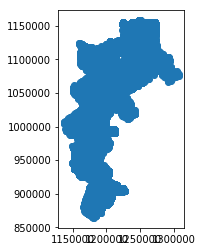

In [7]:
pts.plot()

In [6]:
# http://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    fig = plt.figure()
    plt.imshow(logheatmap, cmap=cmap, extent=extent) # showing log heatmap, can show regular so scale makes more intuitive sense
    plt.colorbar()
    plt.gca().invert_yaxis()
    fig.savefig('/Users/codyschank/Dropbox/Insight/my_webapp/static/heat_map.png')


In [7]:
bins=(700,500)
smoothing=1.5

def getx(pt):
    return pt.coords[0][0]

def gety(pt):
    return pt.coords[0][1]

x = pts.oa_lon.values
y = pts.oa_lat.values
heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')


/Users/codyschank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [8]:
my_cm = plt.cm.get_cmap('jet')
mapped_data = my_cm(logheatmap)
mapped_data = np.flip(mapped_data, 0)

In [9]:
hmap = folium.Map(location=[31.12, -97.55], zoom_start=7, width="100%", height="100%" )

img = ImageOverlay(
    name='Mercator projection SW',
    image=mapped_data,
    bounds=[[y.min(), x.min()], [y.max(), x.max()]],
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
)

folium.GeoJson(tx25_shapefile, style_function=lambda feature: {'color' :'white', 'fillOpacity' : 0.0}).add_to(hmap)
hmap.add_child(img)
hmap.save('/Users/codyschank/Dropbox/Insight/my_webapp/static/heat_map.html')